En este notebook se realiza un analisis exploratorio de datos sobre un conjunto de datos relacionado con enfermedades cardíacas. Se construye un pipeline de preprocesamiento y un modelo de ML para predecir la presencia de enfermedad cardíaca en pacientes.

El conjunto de datos contiene información clínica y demografica, y el objetivo es predecir si un paciente presenta o no una enfermedad cardíaca. Este es un problema de clasificación binaria.

Fuente: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset?resource=download

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression


In [35]:
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


Se usa .info() para saber información general de las columnas como cuantas entradas no son nulas y el tipo de dato que contienen.

In [36]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


Se usa .describe() transpuesto para mostrar datos estadisticos de cada columna.

In [37]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1025.0,54.434146,9.072290,29.0,48.0,56.0,61.0,77.0
sex,1025.0,0.695610,0.460373,0.0,0.0,1.0,1.0,1.0
cp,1025.0,0.942439,1.029641,0.0,0.0,1.0,2.0,3.0
trestbps,1025.0,131.611707,17.516718,94.0,120.0,130.0,140.0,200.0
chol,1025.0,246.000000,51.592510,126.0,211.0,240.0,275.0,564.0
fbs,1025.0,0.149268,0.356527,0.0,0.0,0.0,0.0,1.0
restecg,1025.0,0.529756,0.527878,0.0,0.0,1.0,1.0,2.0
thalach,1025.0,149.114146,23.005724,71.0,132.0,152.0,166.0,202.0
exang,1025.0,0.336585,0.472772,0.0,0.0,0.0,1.0,1.0
oldpeak,1025.0,1.071512,1.175053,0.0,0.0,0.8,1.8,6.2


Las 14 columnas que tiene el dataset son:

age: Edad del paciente

sex: Sexo (1 = masculino, 0 = femenino)

cp: Tipo de dolor en el pecho

trestbps: Presión arterial en reposo

chol: Colesterol sérico

fbs: Azúcar en sangre en ayunas

restecg: Resultados electrocardiograficos en reposo

thalach: Frecuencia cardíaca máxima alcanzada

exang: Angina inducida por ejercicio

oldpeak: Depresión del segmento ST inducida por ejercicio

slope: Pendiente del segmento ST por ejercicio 

ca: Numero de vasos sanguineos principales coloreados por la Fluoroscopia

thal: resultado en pruebaa de talio (0 = normal, 1 = defecto fijo, 2 = defecto reversible)

target: Presencia de enfermedad cardíaca (1 = si, 0 = no)

Definición del problema

El objetivo es construir un modelo que permita predecir si un paciente presenta enfermedad cardíaca utilizando variables clinicas y demograficas.
Este es un problema de clasificación binaria, donde la variable objetivo es target.

In [38]:
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']

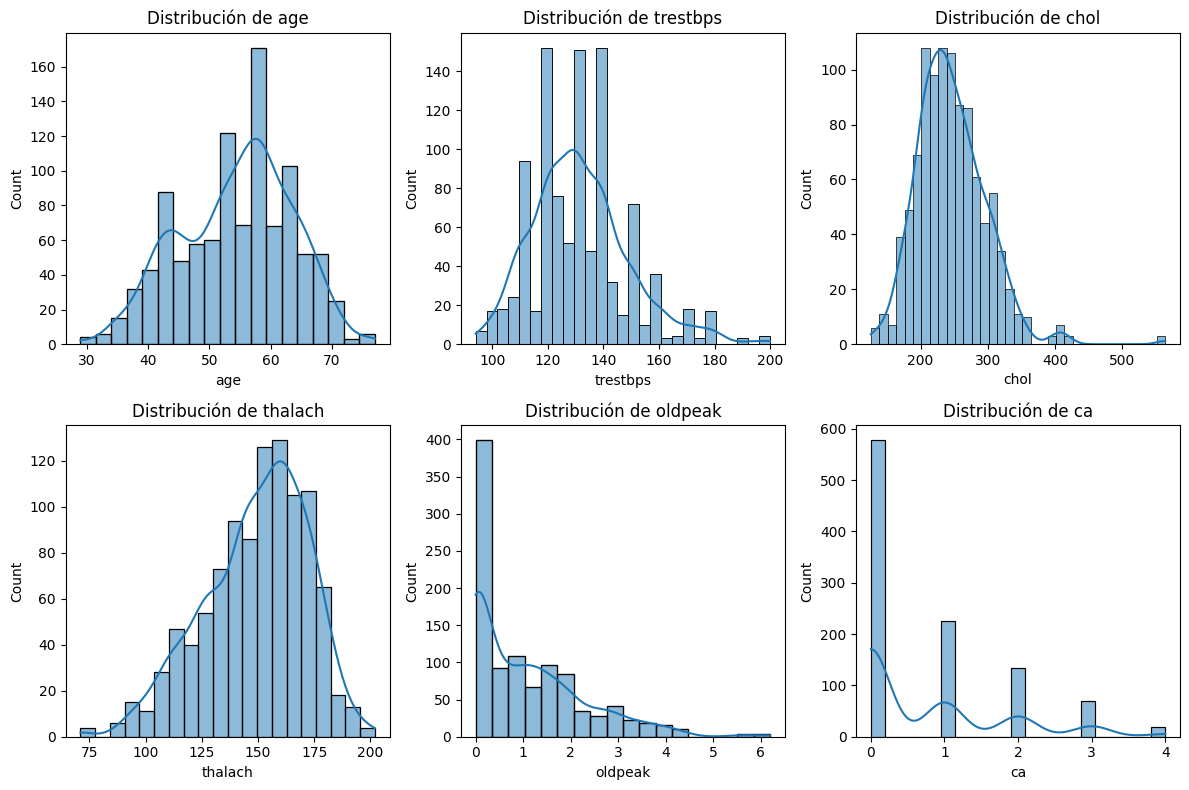

In [48]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for ax, col in zip(axs.ravel(), numerical_cols):
    sns.histplot(data[col], kde=True, ax=ax)
    ax.set_title(f'Distribución de {col}')

plt.tight_layout()

Las variables numericas muestran patrones consistentes con datos clínicos reales. La edad presenta una distribución aproximadamente normal, concentrandose principalmente entre los 45 y 65 años, lo que indica que la mayoria de los pacientes pertenecen a grupos de mediana edad. La presión arterial en reposo (trestbps) y el colesterol  presentan distribuciones ligeramente asimetricas a la derecha, con algunos valores extremos elevados, lo cual es comun en variables biomédicas. La variable thalach muestra una distribución cercana a la normal, mientras que oldpeak presenta una fuerte asimetria positiva, con la mayoria de los valores cercanos a cero y pocos casos con valores altos, indicando distintos niveles de depresión del segmento ST inducida por ejercicio.

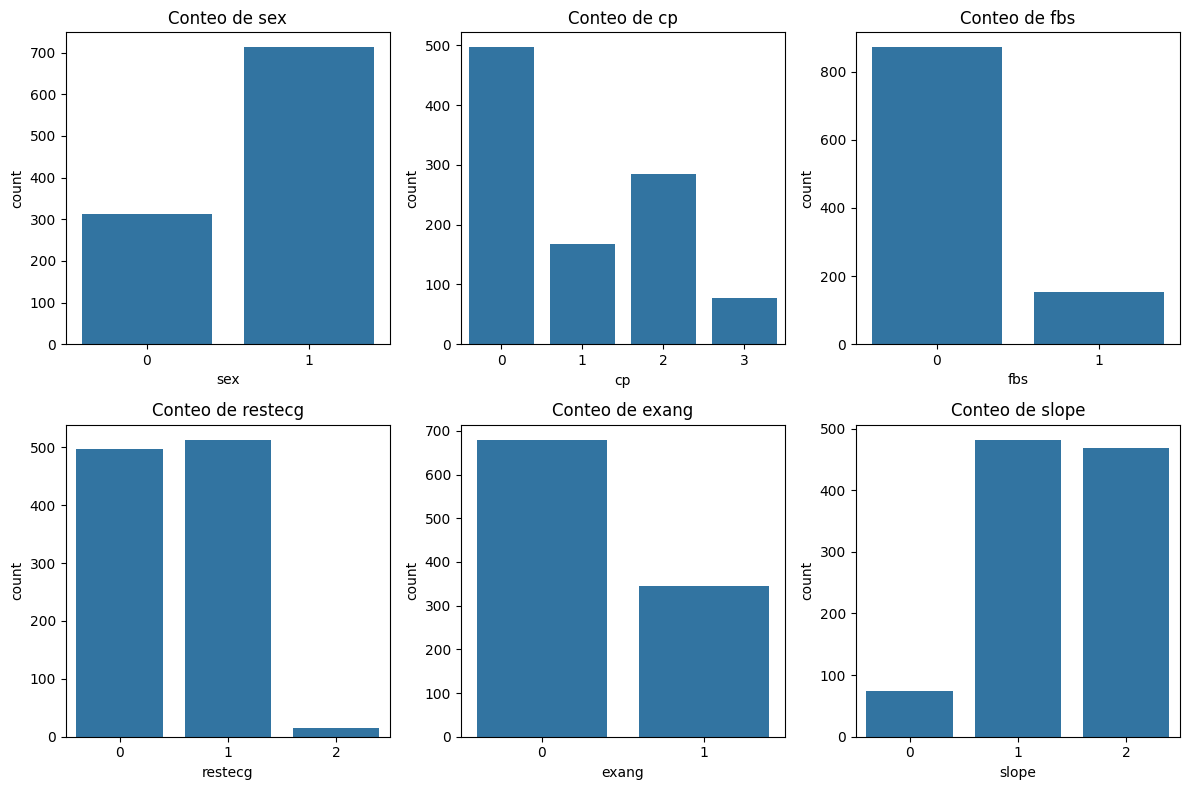

In [40]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for ax, col in zip(axs.ravel(), categorical_cols):
    sns.countplot(data=data, x=col, ax=ax)
    ax.set_title(f'Conteo de {col}')

plt.tight_layout()

En las variables categoricas, se observa mayor proporción de pacientes masculinos. El tipo de dolor en el pecho y los resultados de restecg no se distribuyen de forma uniforme. La mayoria de los pacientes no presenta glucosa elevada en ayunas (fbs) ni angina inducida por ejercicio (exang), lo que aporta información relevante para el análisis predictivo.

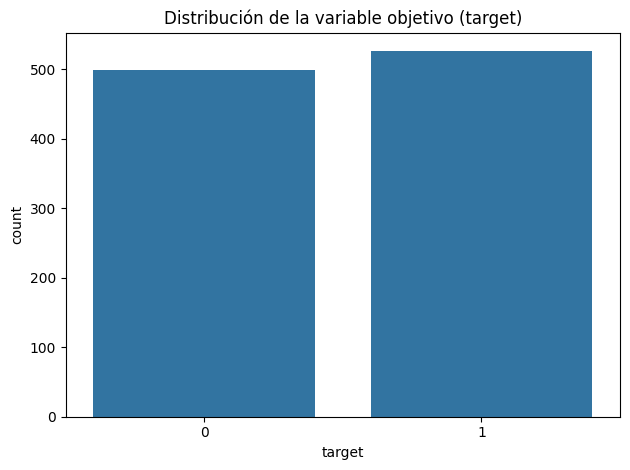

In [41]:
sns.countplot(data=data, x='target')
plt.title('Distribución de la variable objetivo (target)')
plt.tight_layout()


La variable objetivo se encuentra relativamente balanceada entre pacientes con y sin enfermedad cardíaca.

In [42]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [43]:
(data.isnull().mean() * 100).sort_values(ascending=False)

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64

Transformaciones a variables numericas

Imputacion con la media: aunque no hay valores nulos, se incluye para robustez del pipeline.

Estandarización (StandardScaler): estas variables presentan diferentes escalas y algunas distribuciones asimétricas, por lo que escalar mejora el desempeño de modelos lineales como la regresión logística.


Transformaciones a variables categoricas

Imputación con el valor más frecuente: por consistencia del pipeline.

OneHotEncoder: son variables categoricas sin un orden numerico real, por lo que se convierten en variables binarias.

In [ ]:
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope']

# Pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

Creación del pipeline de preprocesamiento

In [45]:
from sklearn.model_selection import train_test_split

X = data.drop('target', axis=1)
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Se separa el conjunto de datos en entrenamiento y prueba para entrenar el modelo y evaluar su capacidad de generalización.

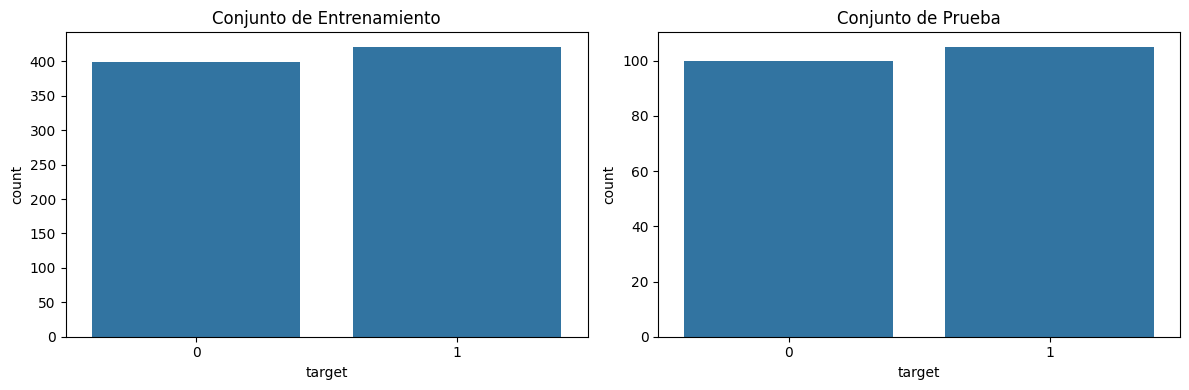

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
sns.countplot(x=y_train, ax=axs[0])
axs[0].set_title('Conjunto de Entrenamiento')
sns.countplot(x=y_test, ax=axs[1])
axs[1].set_title('Conjunto de Prueba')
fig.tight_layout()

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Entrenamiento
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)
y_pred


array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1])

Con el metodo predict podemos mostrar las predicciones usando el modelo de regresión logistica.

In [56]:
X_test['Enfermedad_Predicted'] = y_pred
X_test['Enfermedad_Actual'] = y_test.values
X_test

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Enfermedad_Predicted,Enfermedad_Actual
756,64,1,0,120,246,0,0,96,1,2.2,0,1,2,0,0
353,57,1,0,110,201,0,1,126,1,1.5,1,0,1,0,1
929,60,1,0,130,206,0,0,132,1,2.4,1,2,3,0,0
129,57,1,0,140,192,0,1,148,0,0.4,1,0,1,0,1
591,63,0,0,108,269,0,1,169,1,1.8,1,2,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,67,1,0,120,237,0,1,71,0,1.0,1,0,2,0,0
218,46,1,0,140,311,0,1,120,1,1.8,1,2,3,0,0
564,56,1,0,132,184,0,0,105,1,2.1,1,1,1,0,0
426,54,0,2,160,201,0,1,163,0,0.0,2,1,2,1,1


Se puede ver el comportamiento del modelo agregando columnas de valor de prueba y el predicho para ver la precisión del modelo.